<a href="https://colab.research.google.com/github/dietmarja/LLM-Elements/blob/main/evaluation/model_evaluation_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found existing installation: pyarrow 14.0.2
Uninstalling pyarrow-14.0.2:
  Successfully uninstalled pyarrow-14.0.2
Found existing installation: cudf-cu12 24.4.1
Uninstalling cudf-cu12-24.4.1:
  Successfully uninstalled cudf-cu12-24.4.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

5% of AG News dataset loaded successfully


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/380 [00:00<?, ? examples/s]

Dataset preprocessed successfully


Using existing train/test split
Starting training ...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.236900,0.396120,0.876316


Epoch,Training Loss,Validation Loss,Accuracy
1,0.236900,0.396120,0.876316
2,0.357400,0.385424,0.889474


Training completed


Evaluation result: {'eval_loss': 0.3854239881038666, 'eval_accuracy': 0.8894736842105263, 'eval_runtime': 166.6845, 'eval_samples_per_second': 2.28, 'eval_steps_per_second': 0.144, 'epoch': 2.0}
Loss plot saved successfully at /content/charts/loss_plot.png
Confusion matrix saved successfully at /content/charts/confusion_matrix.png
Classification report saved successfully at /content/charts/classification_report.txt
Charts and report have been saved in the 'charts' folder.
Current working directory: /content
Contents of charts folder:
['loss_plot.png', 'confusion_matrix.png', 'classification_report.txt']
Attempting to display: /content/charts/loss_plot.png


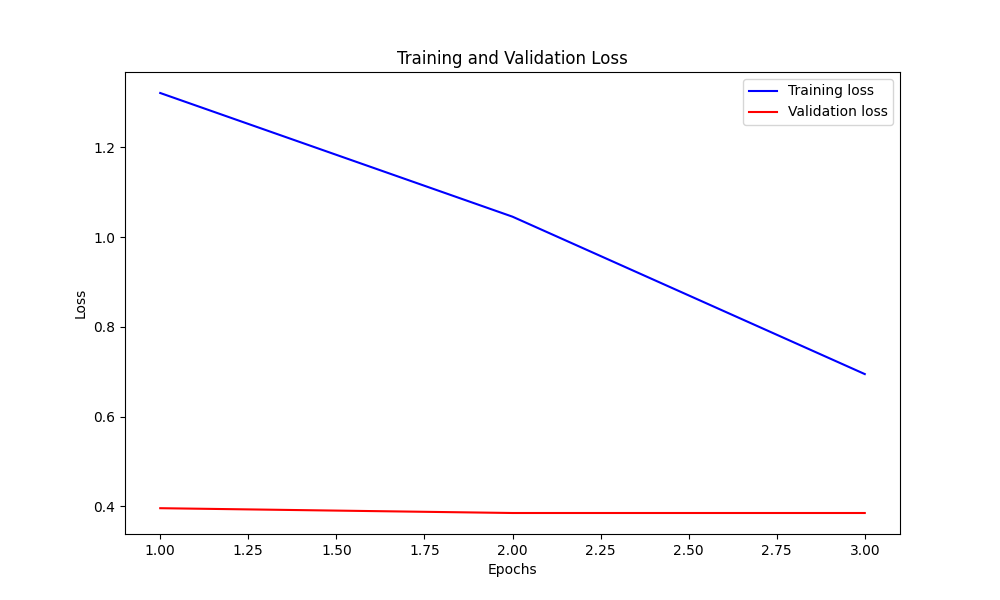

Attempting to display: /content/charts/confusion_matrix.png


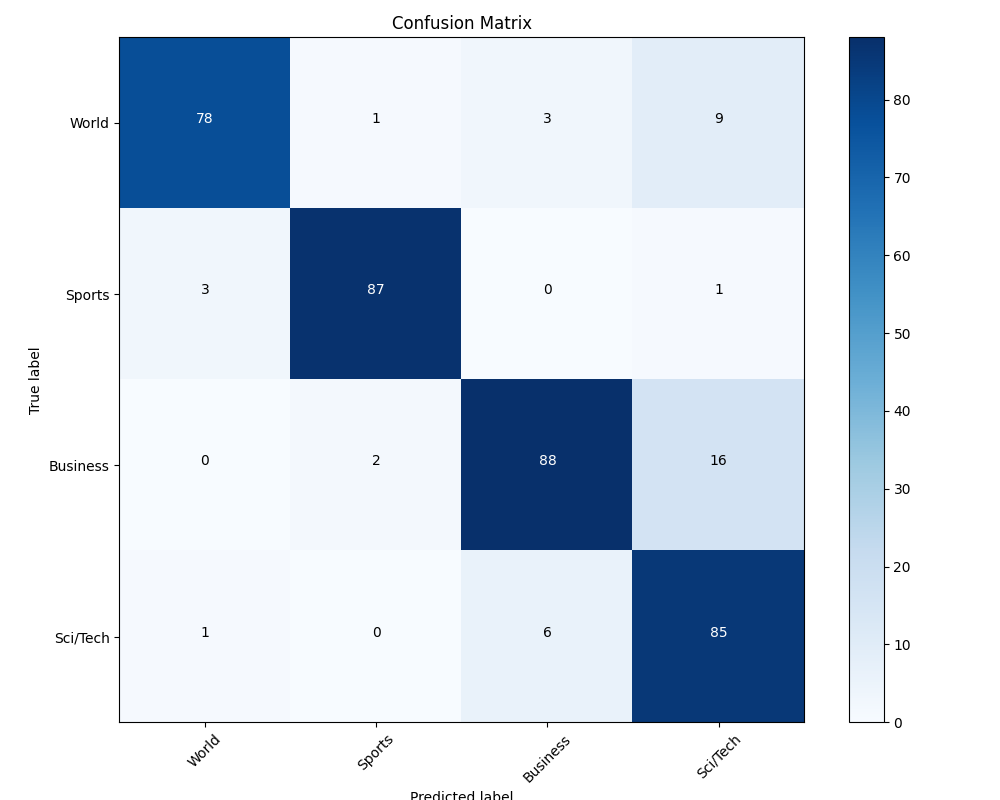

Attempting to read: charts/classification_report.txt
              precision    recall  f1-score   support

       World       0.95      0.86      0.90        91
      Sports       0.97      0.96      0.96        91
    Business       0.91      0.83      0.87       106
    Sci/Tech       0.77      0.92      0.84        92

    accuracy                           0.89       380
   macro avg       0.90      0.89      0.89       380
weighted avg       0.90      0.89      0.89       380



In [1]:
# Multi-class Classification using
# "bert-base-uncased" the AG News dataset from Hugging Face

# Uninstall potentially conflicting packages
!pip uninstall -y pyarrow datasets cudf-cu12
!pip install accelerate -U

# Install specific versions of necessary packages
!pip install pyarrow==14.0.1
!pip install datasets==2.11.0
!pip install cudf-cu12==24.4.1
!pip install transformers evaluate matplotlib scikit-learn multiprocess --upgrade

import os
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from evaluate import load
from sklearn.metrics import confusion_matrix, classification_report

# Verify installations
import pyarrow
print(f"pyarrow version: {pyarrow.__version__}")
import datasets
print(f"datasets version: {datasets.__version__}")

# Create a directory for charts
charts_dir = "charts"
try:
    os.makedirs(charts_dir, exist_ok=True)
    print(f"Charts directory created successfully at {os.path.abspath(charts_dir)}")
except Exception as e:
    print(f"Error creating charts directory: {e}")

# Load the pre-trained model and tokenizer
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the AG News dataset from Hugging Face and take 5% of it
dataset = load_dataset("ag_news")
dataset = dataset.shuffle(seed=42)
dataset['train'] = dataset['train'].select(range(int(len(dataset['train']) * 0.05)))
dataset['test'] = dataset['test'].select(range(int(len(dataset['test']) * 0.05)))
print("5% of AG News dataset loaded successfully")

# Preprocess the dataset
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=128)

encoded_dataset = dataset.map(preprocess_function, batched=True)
print("Dataset preprocessed successfully")

# Set the evaluation metrics
metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    accuracy = metric.compute(predictions=predictions, references=labels)
    return accuracy

# Setup the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=10,
)

# Split the dataset into train and validation sets
train_dataset = encoded_dataset['train']
eval_dataset = encoded_dataset['test']
print("Using existing train/test split")

# Set up the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
print("Starting training ...")
trainer.train()
print("Training completed")

# Evaluate the model
eval_result = trainer.evaluate()
print(f"Evaluation result: {eval_result}")

# Plot training and validation loss
history = trainer.state.log_history
train_loss = [x['loss'] for x in history if 'loss' in x and 'eval_loss' not in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

if train_loss and val_loss:
    # Ensure the same number of points for both losses
    min_len = min(len(train_loss), len(val_loss))
    train_loss = train_loss[:min_len]
    val_loss = val_loss[:min_len]

    epochs = range(1, min_len + 1)

    try:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        loss_plot_path = os.path.join(charts_dir, 'loss_plot.png')
        plt.savefig(loss_plot_path)
        plt.close()
        print(f"Loss plot saved successfully at {os.path.abspath(loss_plot_path)}")
    except Exception as e:
        print(f"Error creating loss plot: {e}")
else:
    print("Not enough data to create loss plot")

# Get predictions for the test set
test_preds = trainer.predict(eval_dataset).predictions
test_labels = eval_dataset['label']

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds.argmax(axis=1))

# Plot confusion matrix
try:
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(4)
    plt.xticks(tick_marks, ['World', 'Sports', 'Business', 'Sci/Tech'], rotation=45)
    plt.yticks(tick_marks, ['World', 'Sports', 'Business', 'Sci/Tech'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    cm_plot_path = os.path.join(charts_dir, 'confusion_matrix.png')
    plt.savefig(cm_plot_path)
    plt.close()
    print(f"Confusion matrix saved successfully at {os.path.abspath(cm_plot_path)}")
except Exception as e:
    print(f"Error creating confusion matrix plot: {e}")

# Generate classification report
target_names = ['World', 'Sports', 'Business', 'Sci/Tech']  # AG News categories
report = classification_report(test_labels, test_preds.argmax(axis=1), target_names=target_names)

# Save classification report to a file
report_path = os.path.join(charts_dir, 'classification_report.txt')
try:
    with open(report_path, 'w') as f:
        f.write(report)
    print(f"Classification report saved successfully at {os.path.abspath(report_path)}")
except Exception as e:
    print(f"Error saving classification report: {e}")

print("Charts and report have been saved in the 'charts' folder.")

# Print current working directory and list contents of charts folder
print(f"Current working directory: {os.getcwd()}")
print("Contents of charts folder:")
try:
    print(os.listdir(charts_dir))
except Exception as e:
    print(f"Error listing charts directory: {e}")

# Display charts and report
from IPython.display import Image, display

full_path_loss = os.path.abspath(loss_plot_path)
full_path_cm = os.path.abspath(cm_plot_path)

print(f"Attempting to display: {full_path_loss}")
display(Image(filename=full_path_loss))

print(f"Attempting to display: {full_path_cm}")
display(Image(filename=full_path_cm))

print(f"Attempting to read: {report_path}")
try:
    with open(report_path, 'r') as f:
        print(f.read())
except Exception as e:
    print(f"Error reading classification report: {e}")

Attempting to display: /content/charts/loss_plot.png


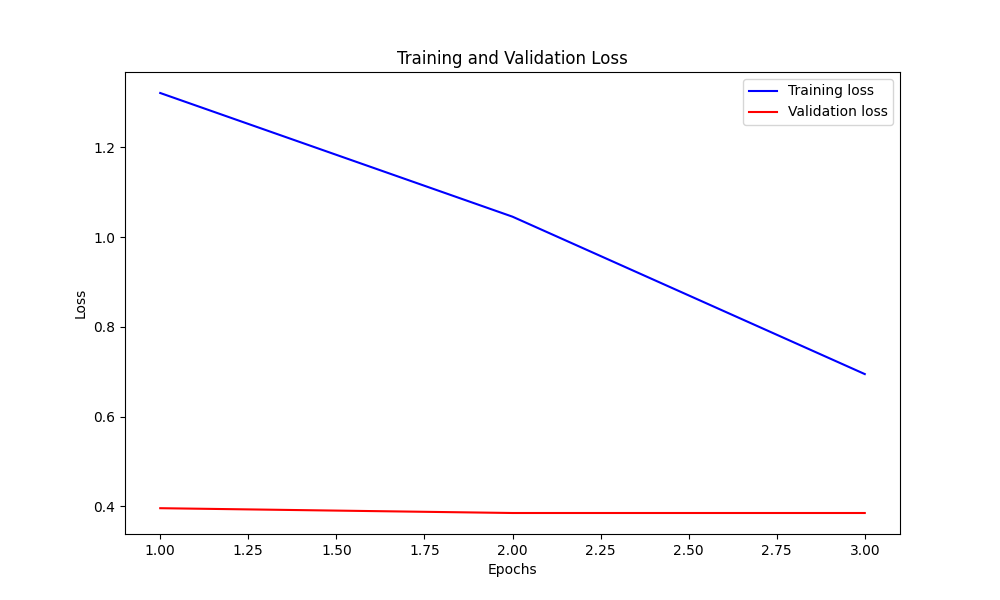

Attempting to display: /content/charts/confusion_matrix.png


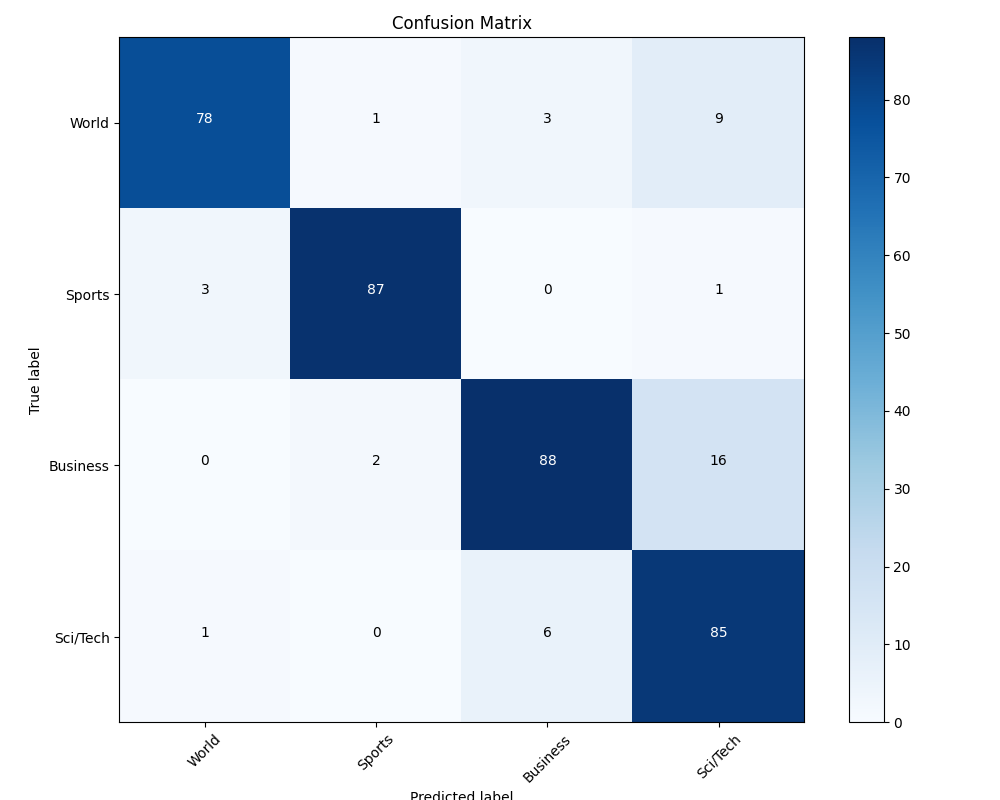

Attempting to read: /content/charts/classification_report.txt
              precision    recall  f1-score   support

       World       0.95      0.86      0.90        91
      Sports       0.97      0.96      0.96        91
    Business       0.91      0.83      0.87       106
    Sci/Tech       0.77      0.92      0.84        92

    accuracy                           0.89       380
   macro avg       0.90      0.89      0.89       380
weighted avg       0.90      0.89      0.89       380



In [2]:
from IPython.display import Image, display
import os

full_path_loss = os.path.abspath('charts/loss_plot.png')
full_path_cm = os.path.abspath('charts/confusion_matrix.png')

print(f"Attempting to display: {full_path_loss}")
display(Image(filename=full_path_loss))

print(f"Attempting to display: {full_path_cm}")
display(Image(filename=full_path_cm))

report_path = os.path.abspath('charts/classification_report.txt')
print(f"Attempting to read: {report_path}")
try:
    with open(report_path, 'r') as f:
        print(f.read())
except Exception as e:
    print(f"Error reading classification report: {e}")